# Training set generation
### Create a set of perturbations with a benzene scaffold that encompasses the whole of 'FEP-space'

In [1]:
import pandas as pd

from rdkit import Chem, DataStructs
from rdkit.Chem import rdmolops, rdMolAlign
from rdkit.Chem import Draw, rdFMCS, AllChem, rdmolfiles, Descriptors, rdchem, rdMolDescriptors
from rdkit.Chem.AtomPairs import Pairs
from rdkit.Chem import Draw

from rdkit.Chem.Draw import IPythonConsole

from IPython.display import display
from IPython.display import SVG,Image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import re

import subprocess

import os
import glob
import csv
from tqdm.notebook import tqdm
import itertools

## 1. Collect FEP-space SMARTS based on fully-connected FEP benchmarking sets

In [2]:
def CountHAChange(fragment1_mol, fragment2_mol):
    """Takes in two rdkit fragment molecules, counts heavy atom changes and returns the number."""
    fragA_smiles = Chem.MolToSmiles(fragA)
    fragB_smiles = Chem.MolToSmiles(fragB)  
    
    double_letter_elements = ["Cl", "Br", "Si"]

    # assign a score based on n_ha transformed:
    transform_score = 0
    for frag_A, frag_B in itertools.zip_longest(fragA_smiles.split("."), fragB_smiles.split(".")):

        # clean up the strings by just retaining letters for easier counting:
        if frag_A:
            fragA_atoms = ''.join(x for x in frag_A if x.isalpha())
        else:
            fragA_atoms = "X"
        if frag_B:
            fragB_atoms = ''.join(x for x in frag_B if x.isalpha())
        else:
            fragB_atoms = "X"
            
        
        # a substitution counts as a single-atom change:
        if len(fragA_atoms) == len(fragB_atoms):
            transform_score += 1
        
        elif len(fragA_atoms) != len(fragB_atoms):
            # add number of heavy atoms changed.
            if len(fragA_atoms) > len(fragB_atoms):
                transform_score += len(fragA_atoms)
            else:
                transform_score += len(fragB_atoms)
        
        # correct for double-letter elements by subtracting 1.
        for elem in double_letter_elements:
            if elem in fragA_atoms:
                transform_score -= 1
            if elem in fragB_atoms:
                transform_score -= 1
            

    return transform_score, fragA_smiles, fragB_smiles

In [3]:
def constructSmarts(lig_mol, mcs_object):
    """
    Given a ligand and MCS (generated with a second ligand), construct an alternative SMARTS that contains
    information on the anchor atom (i.e. the atom in the MCS the perturbed R-group is attached to.)
    
    Get all neighbour indices of the fragment atoms in the original molecule.  
    The (single) index that is in the neighbour indices but not in the fragment 
    indices (set difference) is the atom we want. Anchor atoms and fragments are 
    in the same order because of consistent RDKit indexing.
    """
    # get the fragments by subtracting MCS from ligand.
    lig_fragments = Chem.ReplaceCore(lig_mol, Chem.MolFromSmarts(mcs_object.smartsString))
       
    # get the atom indices for the MCS object.
    mcs_indices = lig_mol.GetSubstructMatch(Chem.MolFromSmarts(mcs_object.smartsString))

    # get all the indices for the ligand.
    ligand_indices = set([x for x in range(0, lig_mol.GetNumAtoms())])

    # get all the fragment indices.
    non_mcs_indices = set(ligand_indices) - set(mcs_indices)


    new_smarts = None
    anchor_atoms = []

    for frag_idx in non_mcs_indices:
        # get the neighbours for this fragment atom.
        nghbrs = lig_mol.GetAtomWithIdx(frag_idx).GetNeighbors()

        for nghbr in nghbrs:
            # find the set difference.
            if not nghbr.GetIdx() in non_mcs_indices:
                anchor_atoms.append(lig_mol.GetAtomWithIdx(nghbr.GetIdx()).GetSmarts())

    for anchor, molfrag in zip(anchor_atoms, Chem.GetMolFrags(lig_fragments, asMols=True, sanitizeFrags=False)):
        # clean up anchor. We really only care about aromatic vs non-aromatic etc.
        anchor = anchor.replace("@","").replace("[","").replace("]","")
    
        # for each fragment, we construct the smarts as [anchor*]atoms which fits with SMARTS logic.
        # Check https://www.daylight.com/dayhtml/doc/theory/theory.smarts.html
        # frag_smiles sometimes contains two dummy attachment points (in cases of ring fragments),
        # but for our purposes it should be OK to only denote the first dummy with the anchor.
        frag_smarts = Chem.MolToSmiles(molfrag)

        # we paste the anchor atom in front of the dummy notation in the SMARTS string. We need to retain the dummy
        # because this can come in handy when creating R groups on a scaffold (e.g. in case of fused ring perts).
        frag_smarts_anchored = anchor+frag_smarts

        # build the new SMARTS string. Insert a "." when there is already a fragment in the new string.
        if not new_smarts:
            new_smarts = frag_smarts_anchored
        else:
            new_smarts += "."+frag_smarts_anchored
    
    # sometimes the picked ligand is the actual MCS so there are no pert SMARTS.
    if not new_smarts:
        new_smarts = ""
        
    return new_smarts

In [4]:
path = "fep_ref_ligands/"
fep_dirs = [f.path for f in os.scandir(path) if f.is_dir()]


with open('fep_ref_ligands/fep_benchmarking_perts.csv', 'w') as info_file:

    writer_infos = csv.writer(info_file)
    
    for fep_set_dir in fep_dirs:
        
        # exclude some folders that we do not want to use:
        exclude_names = [".ipynb_checkpoints", "testset_selection"]
        if fep_set_dir.split("/")[-1] in exclude_names:
            continue
        
        tgt_name = fep_set_dir.split("/")[-1]
        print(tgt_name)
        
        # get all ligands and make all combinations.
        ligand_paths = glob.glob(fep_set_dir+"/*.sdf")
        fully_connected = list(itertools.combinations(ligand_paths, 2))

        # iterate over possible perts.
        for pert in tqdm(fully_connected):
            ligA_name = pert[0].split("/")[-1].replace(".sdf","")
            ligB_name = pert[1].split("/")[-1].replace(".sdf","")
            pertname = ligA_name+"~"+ligB_name


            # Read in the molecules.
            ligA = Chem.SDMolSupplier(pert[0])[0]
            ligB = Chem.SDMolSupplier(pert[1])[0]  
            
            # get MCS and fragments (i.e. perturbed R-groups).
            mcs = rdFMCS.FindMCS([ligA, ligB], ringMatchesRingOnly=True, completeRingsOnly=True)
            # sometimes with small organic molecules mcs returns none because the mcs is single-atom. Exclude these.
            if not mcs:
                continue
            # subtract the MCS to get the perturbed (i.e. non-mcs) atoms.
            fragA = Chem.ReplaceCore(ligA, Chem.MolFromSmarts(mcs.smartsString))
            fragB = Chem.ReplaceCore(ligB, Chem.MolFromSmarts(mcs.smartsString))

            # count the number of perturbed heavy atoms.
            ha_change_count, fragA_smiles, fragB_smiles = CountHAChange(fragA, fragB)
            
            # continue only with perturbations that have fewer than 10 heavy atom changes.
            if ha_change_count > 10:
                continue
            

            # get the alternate perturbation SMARTS
            pert_smartsA = constructSmarts(ligA, mcs)
            pert_smartsB = constructSmarts(ligB, mcs)
            pert_smarts = pert_smartsA+"~"+pert_smartsB
            
            # continue only with perturbations that do not contain charges as this is out of scope.
            if "+" in pert_smarts or "-" in pert_smarts:
                continue

            # write out perturbation.
            writer_infos.writerow([tgt_name, pertname,pert_smarts,ha_change_count])  


cdk8


  0%|          | 0/528 [00:00<?, ?it/s]

pfkfb3


  0%|          | 0/780 [00:00<?, ?it/s]

shp2


  0%|          | 0/325 [00:00<?, ?it/s]

galectin


  0%|          | 0/28 [00:00<?, ?it/s]

eg5


  0%|          | 0/378 [00:00<?, ?it/s]

hif2a


  0%|          | 0/861 [00:00<?, ?it/s]

cmet


  0%|          | 0/66 [00:00<?, ?it/s]

pde2


  0%|          | 0/210 [00:00<?, ?it/s]

thrombin


  0%|          | 0/55 [00:00<?, ?it/s]

p38


  0%|          | 0/561 [00:00<?, ?it/s]

cdk2


  0%|          | 0/120 [00:00<?, ?it/s]

bace


  0%|          | 0/630 [00:00<?, ?it/s]

mcl1


  0%|          | 0/861 [00:00<?, ?it/s]

syk


  0%|          | 0/946 [00:00<?, ?it/s]

ptp1b


  0%|          | 0/253 [00:00<?, ?it/s]

tnks2


  0%|          | 0/351 [00:00<?, ?it/s]

tyk2


  0%|          | 0/120 [00:00<?, ?it/s]

jnk1


  0%|          | 0/210 [00:00<?, ?it/s]

## Build molecules with benzene scaffold abstracted from FEP-space 

Writes both molecule files and a text file that lists all perturbations.

In [4]:
depict_mols = True    # toggle drawing of molecules in algorithm. Depiction slows down loop considerably.

In [5]:
all_bm_perts = pd.read_csv("./fep_ref_ligands/fep_benchmarking_perts.csv", names=["tgt", "pert", "smarts", "n_ha"])
original_length = len(all_bm_perts)
all_bm_perts = all_bm_perts.drop_duplicates(subset="smarts")

print(f"Dropped {original_length - len(all_bm_perts)} duplicates")

all_bm_perts


Dropped 878 duplicates


,tgt,pert,smarts,n_ha
0,cdk8,32~33,~N[1*]C1CC1,3
1,cdk8,32~40,C[1*]N~C[1*]N1CCNCC1,6
2,cdk8,32~18,c[1*]c1cnn(C)c1~N[3*]C.c[1*]:cnn(:[2*])C,7
3,cdk8,32~35,C[1*]N~C[1*]N1CC(O)C1,5
4,cdk8,32~30,C[1*]N~C[1*]N1CC[C@H](O)C1,7
...,...,...,...,...
4666,jnk1,lig_18638-1~lig_18660-1,c[1*]S(C)(=O)=O~C[1*]S(C)(=O)=O,1
4667,jnk1,lig_18638-1~lig_18628-1,c[3*]OC.c[2*]S(C)(=O)=O.c[1*]OC~c[1*]C,8
4668,jnk1,lig_18638-1~lig_18659-1,c[1*]S(C)(=O)=O~C[1*]OC,4
4669,jnk1,lig_18660-1~lig_18628-1,C[1*]S(C)(=O)=O.c[3*]OC.c[2*]OC~c[1*]C,8


In [6]:
def rewriteSMARTS(smarts_string):
    """Given a SMARTS string with possible multiple fragments, return a valid string where the anchor atom 
    is the first atom in each fragment, instead of denoted as [x*] (which is not parsable)."""
    
    frags_1, frags_2 = smarts_string.split("~")
    
    def constructPerFrag(frags_smarts):
        """Splits a ligand's fragments and processes each; puts anchor atom at base of each fragment."""
        fused_ring = False
        frags_whole_rewritten = None
        
        # if trihalo, we can merge that into a single R group (i.e. fragment).
        if "[C*]F.[C*]F.[C*]F" in frags_smarts:
            frags_smarts = frags_smarts.replace("[C*]F.[C*]F.[C*]F", "[C*](F)(F)F")
        elif "[C*]Cl.[C*]Cl.[C*]Cl" in frags_smarts:
            frags_smarts = frags_smarts.replace("[C*]Cl.[C*]Cl.[C*]Cl", "[C*](Cl)(Cl)Cl")
        
        # replace SMARTS notation style for CH with C (will protonate later in workflow anyway)
        frags_smarts = frags_smarts.replace("CH", "C")
        frags_smarts = frags_smarts.replace("C@H", "C")
    
        # now rewrite each fragment.
        for frag in frags_smarts.split("."):
            frag_parsed = None
            if len(frag) == 0:
                frag_parsed = anchor_atom = r_group_smarts = ""
            else: 
                anchor_atom = frag[0]
                r_group_smarts = frag[1:]
    
            if anchor_atom == "n":
                # use non-aromatic nitrogen instead.
                if frag_parsed:
                    frag_parsed += ".N"+r_group_smarts
                else:
                    frag_parsed = "N"+r_group_smarts 
            else:
                # anchor atom is used between R group and scaffold.
                if frag_parsed:
                    frag_parsed += "."+anchor_atom+r_group_smarts
                else:
                    frag_parsed = anchor_atom+r_group_smarts 

            # add the rewritten SMARTS string to the ligand SMARTS string (potentially >1 fragments).      
            if frags_whole_rewritten:
                frags_whole_rewritten += "."+frag_parsed
            else:
                frags_whole_rewritten = frag_parsed
            
            # record if this fragment contains a fused ring (multiple wildcards).  
            if frag_parsed.count("*") == 2:
                fused_ring = True
        
        # in case the fragments for this ligand contain a fused ring (multiple wildcards), reorder such
        # that the fused ring information comes first (simplifies grafting the fragments onto scaffold).
        if fused_ring:
            # get number of wildcards per sub-fragment.
            num_wildcards = [frag_str.count("*") for frag_str in frags_whole_rewritten.split(".")]
            
            # reorder the subfragments by descending number of wildcards (i.e. make fused ring come first).
            reordered = [x for _, x in sorted(zip(num_wildcards, frags_whole_rewritten.split(".")), reverse=True)]
            frags_whole_rewritten = ".".join(reordered)
                  
        return frags_whole_rewritten
    return constructPerFrag(frags_1), constructPerFrag(frags_2)

In [7]:
def graftToScaffold(frag):
    """Given a SMARTS pattern, create a benzene with R groups corresponding to the fragments in the SMARTS"""
    # start with regular benzene.
    main_scaffold = "c1ccccc1"
    scaffold_mol = Chem.MolFromSmiles(main_scaffold)
    
    # abort this perturbation if there are two or more fused rings being perturbed.
    if frag.count(".") == 1 and frag.count("*]") == 4:
        print("Aborting this pert --> two or more fused rings being perturbed.")
        return None

    # abort this perturbation if there are too many R groups such that the 6 carbons on benzene are not enough.
    if frag.count(".") >= 5:
        print("Aborting this pert --> more than 6 R groups.")
        return None        
    
    # loop over the molecules in this fragment.
    for fr in frag.split("."):
        # if the fragment is empty, this side of the perturbation is empty. Exit the loop to just keep benzene.
        if len(fr) == 0:
            break
            
        # count the number of wildcards in this set of fragments.
        if fr.count("*") == 1:
            # in this case we can simply graft the structure onto benzene.
            anchor = fr[0]
            if anchor == "c":
                # removing aromatic anchor will make r_group graft onto benzene directly (making it use the aromatic 
                # benzene carbon as anchor).
                anchor = ""
                
            r_group = fr[5:]

            scaffold_mol = Chem.ReplaceSubstructs(scaffold_mol, 
                                     Chem.MolFromSmiles('C'), 
                                     Chem.MolFromSmiles("C"+anchor+r_group),
                                     replaceAll=False,
                                    )[0]
        else:
            # if >1 wildcards are in the string, we are dealing with a fused ring structure.
            # this is considerably more complicated to graft onto benzene. We will rewrite 
            # the fragment such that it contains the benzene as well; then instead of replacing 
            # a single carbon in the scaffold we will replace it with the newly generated scaffold.            
            new_scaffold = createFusedRingScaffold(fr)
            
            # several forms of fused rings are being excluded (see createFusedRingScaffold() for rationales).
            if new_scaffold is None:
                return None
            else:
                try:
                    scaffold_mol = Chem.ReplaceSubstructs(scaffold_mol, 
                                 Chem.MolFromSmiles("c1ccccc1"), 
                                 Chem.MolFromSmiles(new_scaffold),
                                 replaceAll=False,
                                )[0]
                except:
                    # final error catches. If at this point the fused ring can not be grafted onto the scaffold
                    # it can be discarded as brute-forcing it in would substantially alter the chemistry of 
                    # the benzene scaffold.
                    print("Aborting this pert --> miscellaneous fused ring issue.")
                    return None
        
        # after grafting we need to sanitize.
        try:
            Chem.SanitizeMol(scaffold_mol)
        except:
            print("Aborting this pert --> miscellaneous ring issue.")
    # all done. Checks?
    
    return scaffold_mol    

In [8]:
def createFusedRingScaffold(input_frag):
    """Given a fragment SMARTS that describes a fused ring, create a canonical smiles notation for benzene
    that contains the fused ring.
    """
    # first, verify that the input is indeed a fused ring SMARTS.
    if not input_frag.count("*") > 1:
        raise Exception("Input fragment is not a fused ring SMARTS!", input_frag)
        
    # in some cases, fused rings with double bonds will mess with scaffold aromaticity to such a degree that 
    # building them into our training set becomes complex and introduces noise.
    if "C=[" in input_frag or "]=C" in input_frag:
        print("Aborting this pert --> fused ring double bond interrupts scaffold aromaticity.")
        return None
    
    ########## handle non-aromatic fused rings:
    if not input_frag.count(":") == 2:
        # For our structure, we need everything that is contained within the parentheses of the SMARTS notation.
        fused_ring_atoms = input_frag[input_frag.find("]")+len("["):input_frag.rfind("[")]
        
        # in case of 5 main cycle atoms, remove 1 'C'. This is due to SMARTS grammar and fixes kekulization errors.
        # count the number of atoms in the main cycle of the fused ring.
        fused_ring_string = re.sub(r"\([^()]*\)", "", fused_ring_atoms)
        fused_ring_size = len(fused_ring_string.replace("[", "").replace("]", "").replace("H",""))
        if fused_ring_size >4:
            if "CCC" in fused_ring_atoms:
                fused_ring_atoms = fused_ring_atoms.replace("CCC", "CC", 1)
            elif "CC" in fused_ring_atoms:
                fused_ring_atoms = fused_ring_atoms.replace("CC", "C", 1)
        
        # create the new scaffold string.
        new_scaffold = f"c1cccc2c1{fused_ring_atoms}2"
        
        return new_scaffold
    ########## handle aromatic fused rings:
    # this is much more complex.
    else:

        # we can ignore the anchor atom (assume aromaticity here, accounting for non-aromaticity here would be exceedingly
        # complex). For our structure, we need everything that is contained within the colons of the SMARTS notation.
        fused_ring_atoms = input_frag[input_frag.find(":")+len(":"):input_frag.rfind(":")]

        ##### clean up structure; 
        #in some cases there will be a trailing closing '('.
        if fused_ring_atoms[-1] == "(":
            fused_ring_atoms = fused_ring_atoms[:-1]
        elif fused_ring_atoms[-2:] == "(2":
            fused_ring_atoms = fused_ring_atoms[:-2]
        elif fused_ring_atoms[-3:] == "(C2":
            fused_ring_atoms = fused_ring_atoms[:-3]
        #####
        # in case branch notation for this ring is in the shape of [n*]:ring_atoms(:[n*])branch_atoms,
        # we have to swap ':[n*]' and 'branch_atoms'. The way this is written depends mostly on stereochemistry 
        # and messes up the way we parse.
        attch_pnt_strings = [f"(:[{i}*])" for i in range(10)]

        # count the number of atoms in the main cycle of the fused ring.
        fused_ring_string = re.sub(r"\([^()]*\)", "", fused_ring_atoms)
        fused_ring_size = len(fused_ring_string.replace("[", "").replace("]", "").replace("H",""))
        
        # in case of 5 main cycle atoms, remove 1 'c'. This is due to SMARTS grammar and fixes kekulization errors.
        if fused_ring_size >4:
            if "ccc" in fused_ring_atoms:
                fused_ring_atoms = fused_ring_atoms.replace("ccc", "cc", 1)
            elif "cc" in fused_ring_atoms:
                fused_ring_atoms = fused_ring_atoms.replace("cc", "c", 1)
         

        if any(c.split("])")[-1].isalpha() for c in input_frag) and any(x in input_frag for x in attch_pnt_strings):
            branch_structure = input_frag.split("])")[-1]
            fused_ring_atoms += f"({input_frag.split('])')[-1]})"
            
        # create the new scaffold string.
        new_scaffold = f"c1cccc2c1{fused_ring_atoms}2"

        return new_scaffold

In [9]:
def depictMol(mol):
    """Saves a molecule image and loads it back in and returns it. Allows viewing RDKit molecules during 
    loop iterations. """

    Draw.MolToFile(mol, "tmp_images/tmp.png")
    img = mpimg.imread("tmp_images/tmp.png")
    
    return img    

  0%|          | 0/3794 [00:00<?, ?it/s]

0      >>>>     N[1*]C1CC1


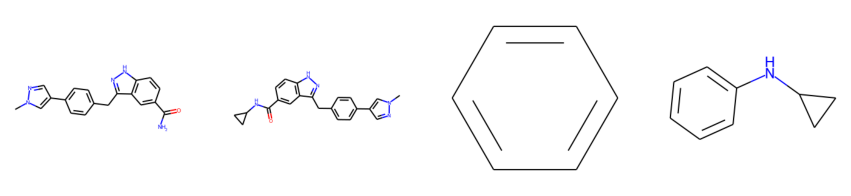

1 C[1*]N     >>>>     C[1*]N1CCNCC1


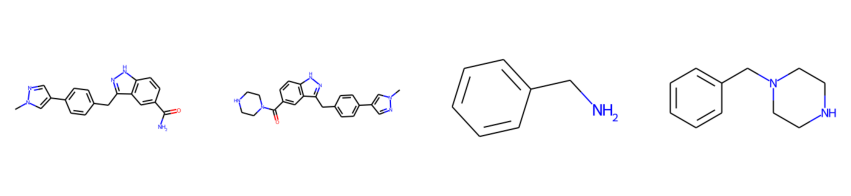

2 c[1*]c1cnn(C)c1     >>>>     c[1*]:cnn(:[2*])C.N[3*]C


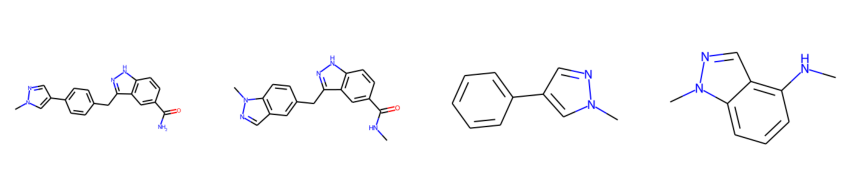

3 C[1*]N     >>>>     C[1*]N1CC(O)C1


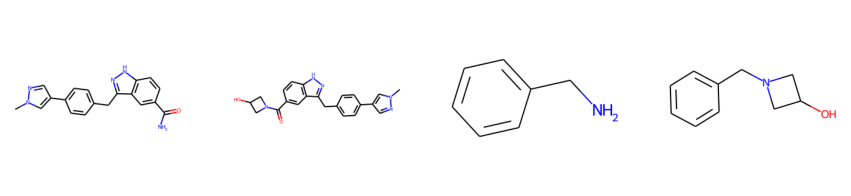

4 C[1*]N     >>>>     C[1*]N1CC[C](O)C1


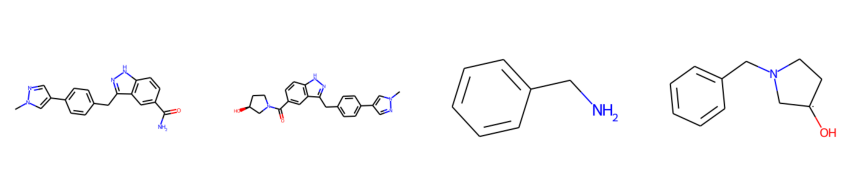

5 c[1*]C(N)=O     >>>>     c[1*]NC(C)=O


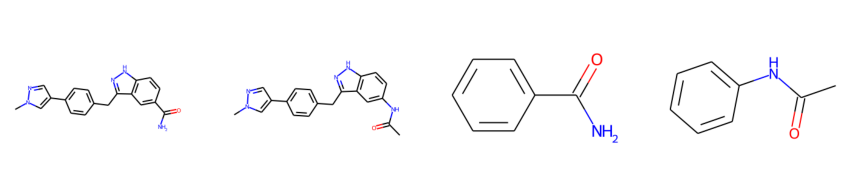

6 c[1*]C(N)=O     >>>>     c[1*]NS(C)(=O)=O


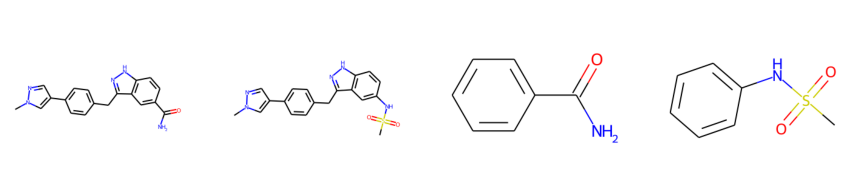

7 C[1*]N     >>>>     C[1*]N1CCCCC1


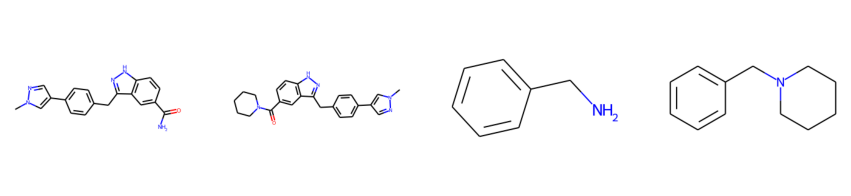

8 C[1*]N     >>>>     C[1*]N1CC(OC)C1


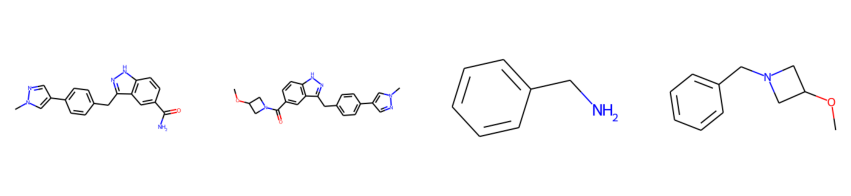

9 c[1*]C(N)=O     >>>>     c[1*]N1CCOCC1


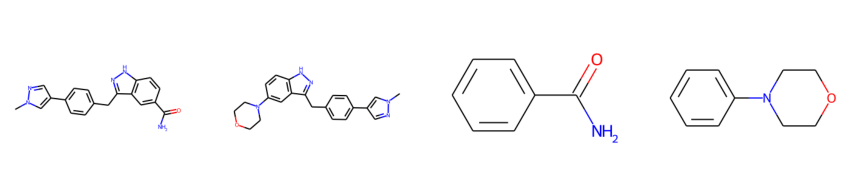

10      >>>>     N[2*]C.C[1*]C(C)(C)O


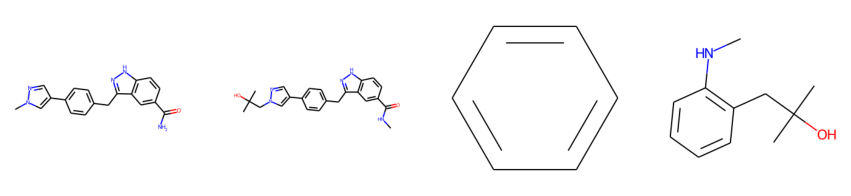

11 c[1*]c1cnn(C)c1     >>>>     N[2*]C.c[1*]C


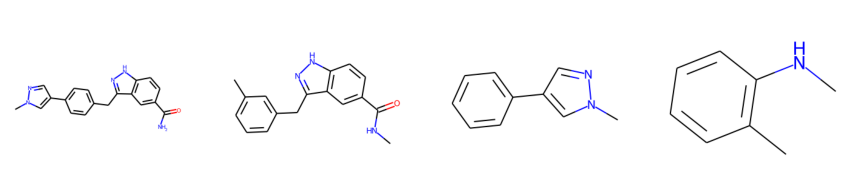

12 c[1*]c1cnn(C)c1     >>>>     N[3*]C.c[1*]OC.c[2*]OC


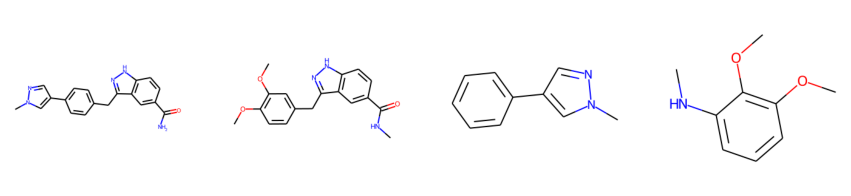

13 c[1*]C(N)=O     >>>>     c[1*]N1CCCC1=O


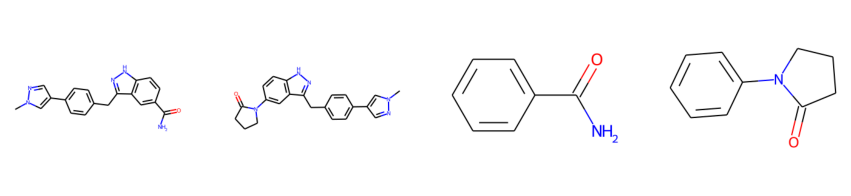

14 c[1*]c1cnn(C)c1     >>>>     c[1*]:n(C)nc:[2*].N[3*]C


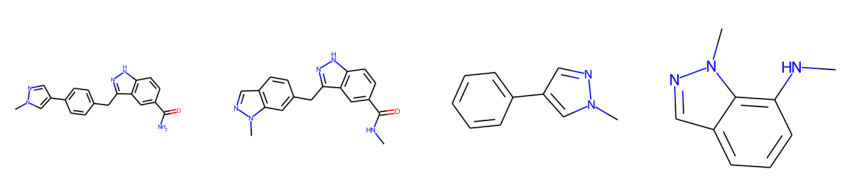

15 c[1*]C(N)=O     >>>>     c[1*]S(=O)(=O)NC1CC1


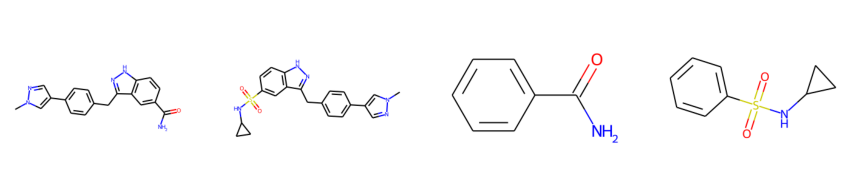

16 c[1*]C(N)=O     >>>>     c[1*]c1cn(C)cn1


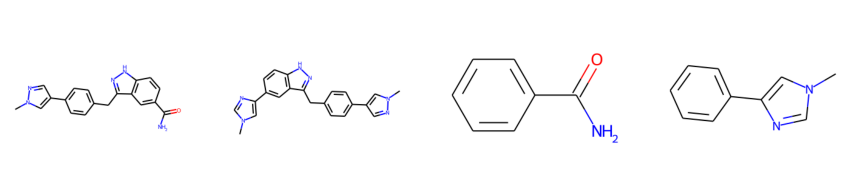

17 C[1*]N     >>>>     C[1*]N1CCCC1


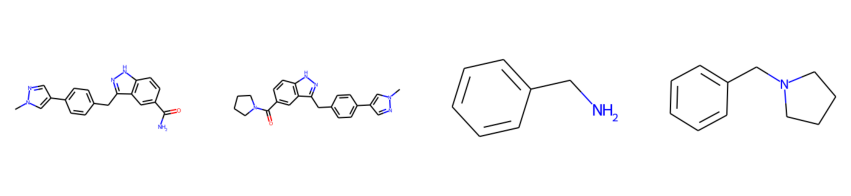

18 C[1*]N     >>>>     C[1*]N1CC(F)(F)C1


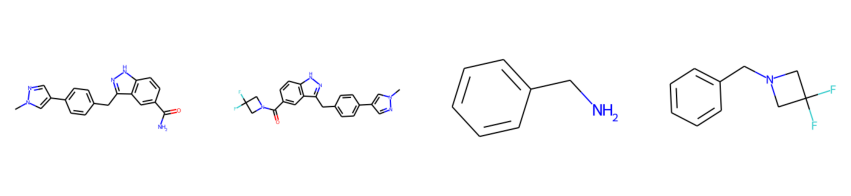

19 C[1*]N     >>>>     C[1*]N1CCOCC1


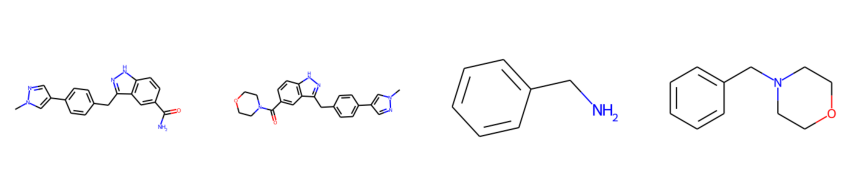

20 c[1*]C(N)=O     >>>>     c[1*]c1nccn1C


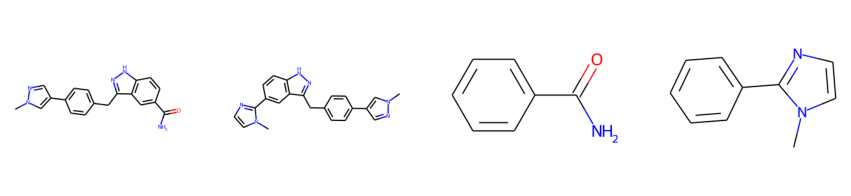

21 C[1*]N     >>>>     C[1*]N1CCC(F)(F)C1


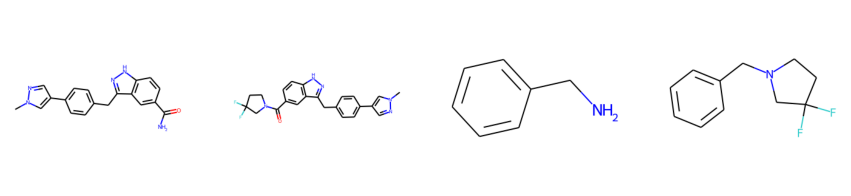

22 c[1*]C(N)=O     >>>>     c[1*]NCCNC(C)=O


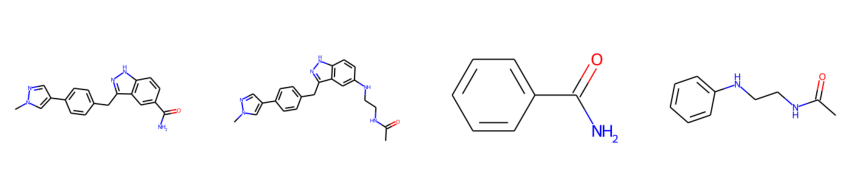

23 C[1*]N     >>>>     C[1*]N1CC[C@@H](O)C1


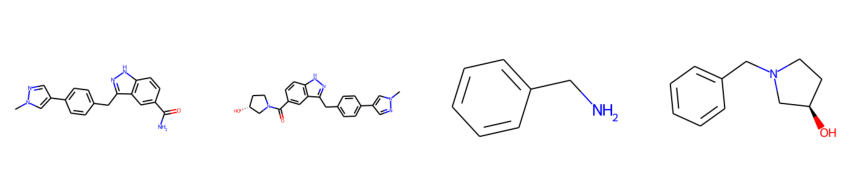

24 c[1*]C(N)=O     >>>>     c[1*]c1cc(N)ccn1


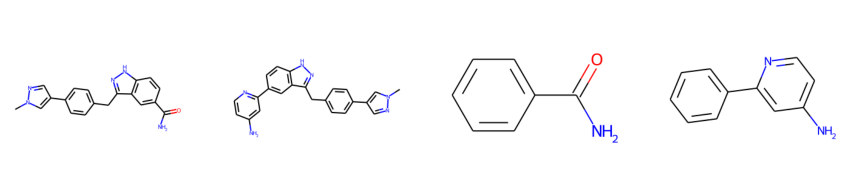

25      >>>>     N[1*]C


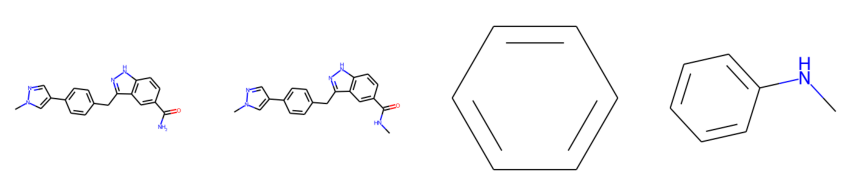

26 C[1*]NC1CC1     >>>>     C[1*]N1CCNCC1


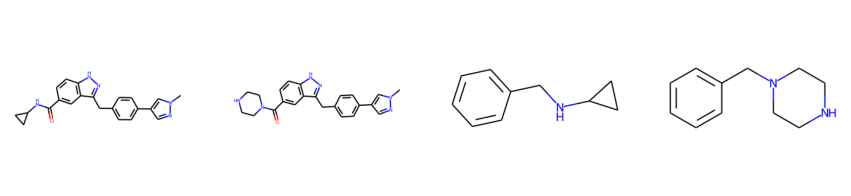

27 c[1*]c1cnn(C)c1.N[2*]C1CC1     >>>>     c[1*]:cnn(:[2*])C.N[3*]C


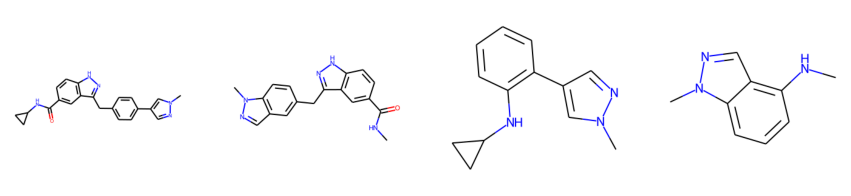

28 C[1*]NC1CC1     >>>>     C[1*]N1CC(O)C1


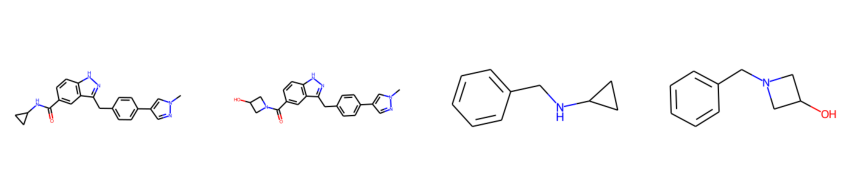

29 C[1*]NC1CC1     >>>>     C[1*]N1CC[C](O)C1


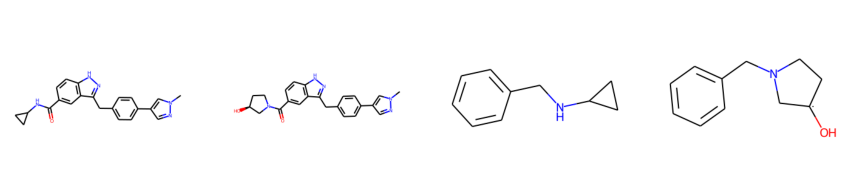

30 c[1*]C(=O)NC1CC1     >>>>     c[1*]NC(C)=O


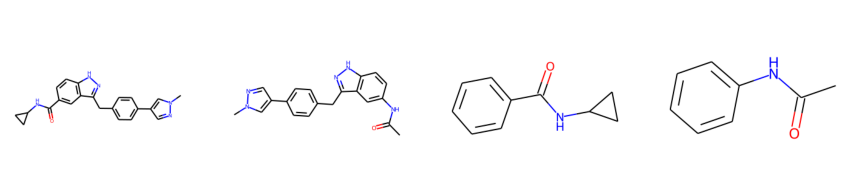

31 c[1*]C(=O)NC1CC1     >>>>     c[1*]NS(C)(=O)=O


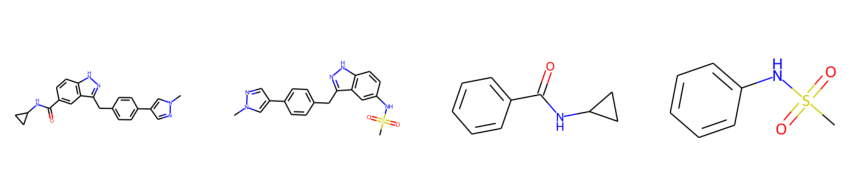

32 C[1*]NC1CC1     >>>>     C[1*]N1CCCCC1


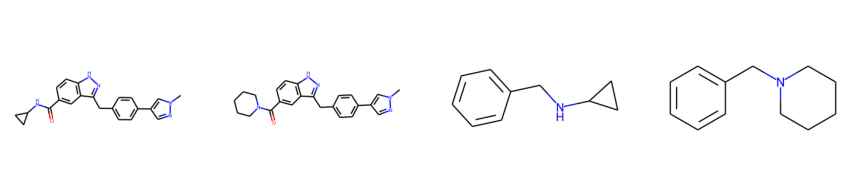

33 C[1*]NC1CC1     >>>>     C[1*]N1CC(OC)C1


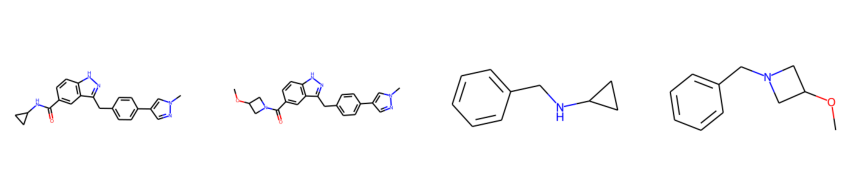

34 c[1*]C(=O)NC1CC1     >>>>     c[1*]N1CCOCC1


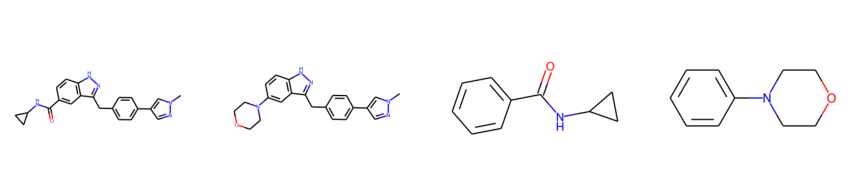

35 N[1*]C1CC1     >>>>     N[2*]C.C[1*]C(C)(C)O


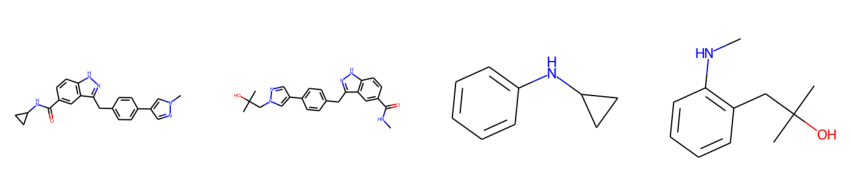

36 c[1*]c1cnn(C)c1.N[2*]C1CC1     >>>>     N[2*]C.c[1*]C


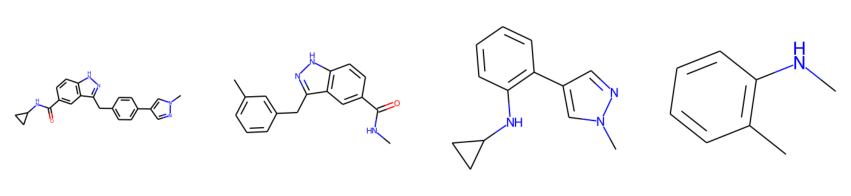

37 c[1*]c1cnn(C)c1.N[2*]C1CC1     >>>>     N[3*]C.c[1*]OC.c[2*]OC


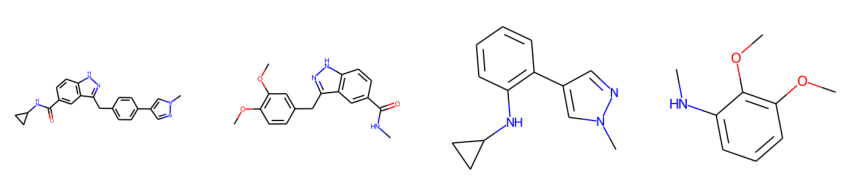

38 c[1*]C(=O)NC1CC1     >>>>     c[1*]N1CCCC1=O


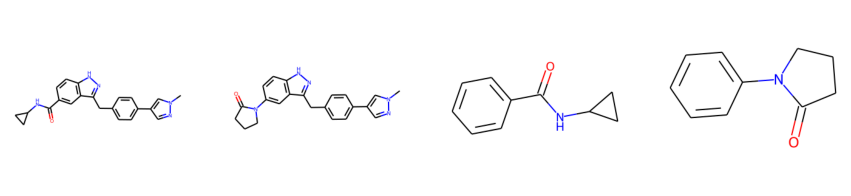

39 c[1*]c1cnn(C)c1.N[2*]C1CC1     >>>>     c[1*]:n(C)nc:[2*].N[3*]C


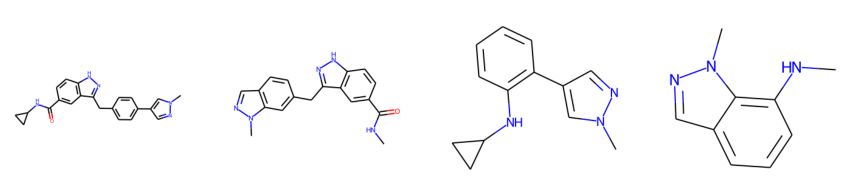

40 c[1*]C(=O)NC1CC1     >>>>     c[1*]S(=O)(=O)NC1CC1


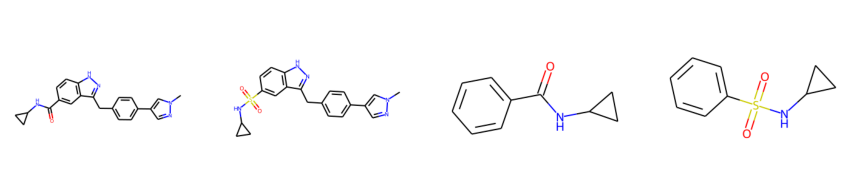

41 c[1*]C(=O)NC1CC1     >>>>     c[1*]c1cn(C)cn1


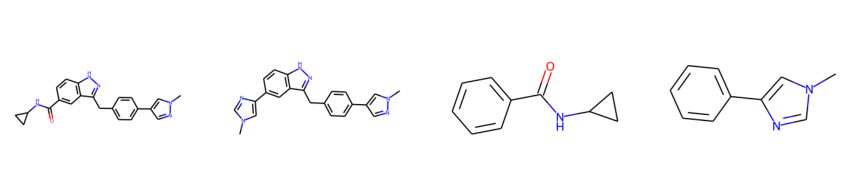

42 C[1*]NC1CC1     >>>>     C[1*]N1CCCC1


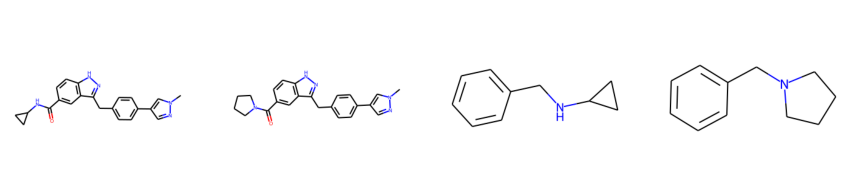

43 C[1*]NC1CC1     >>>>     C[1*]N1CC(F)(F)C1


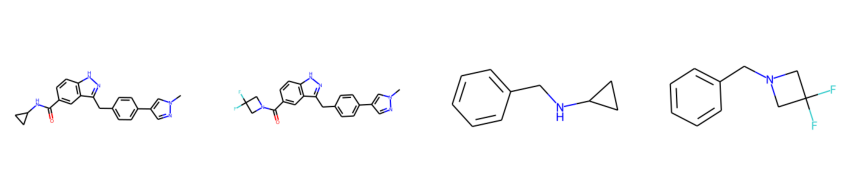

44 C[1*]NC1CC1     >>>>     C[1*]N1CCOCC1


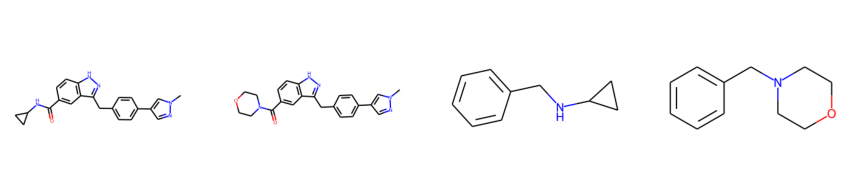

45 c[1*]C(=O)NC1CC1     >>>>     c[1*]c1nccn1C


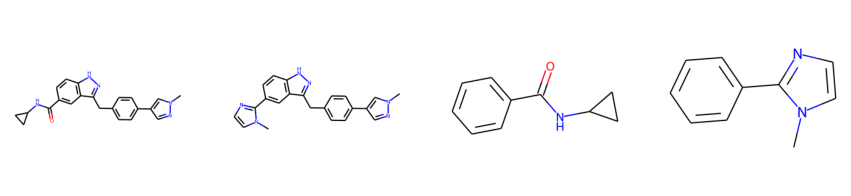

46 C[1*]NC1CC1     >>>>     C[1*]N1CCC(F)(F)C1


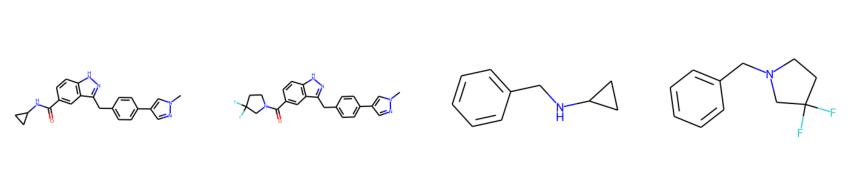

47 c[1*]C(=O)NC1CC1     >>>>     c[1*]NCCNC(C)=O


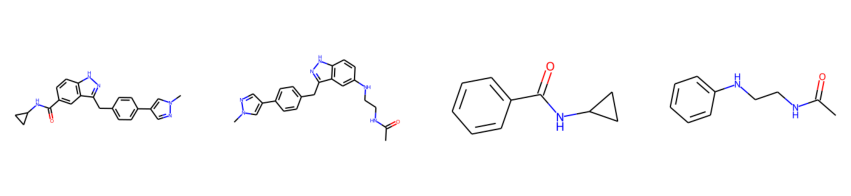

48 C[1*]NC1CC1     >>>>     C[1*]N1CC[C@@H](O)C1


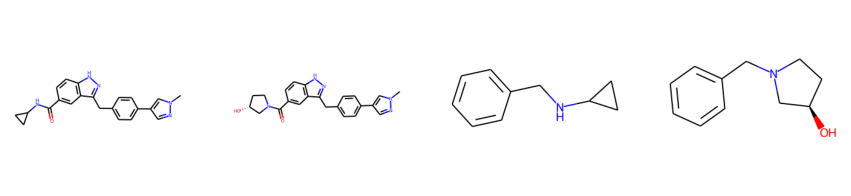

49 c[1*]C(=O)NC1CC1     >>>>     c[1*]c1cc(N)ccn1


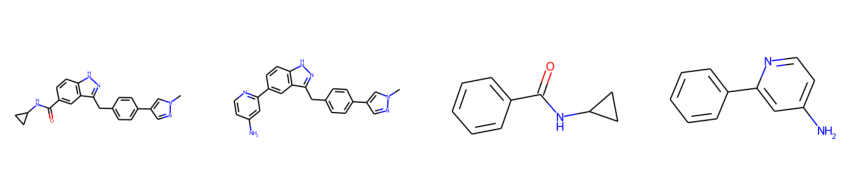

50 N[1*]C1CC1     >>>>     N[1*]C


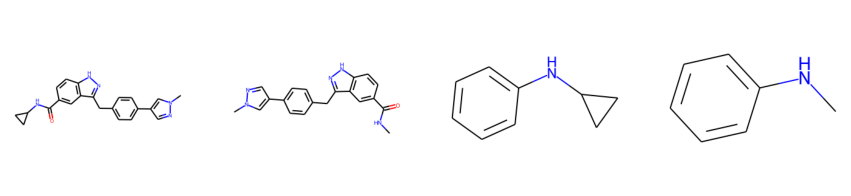

51 N[1*]CCNCC[2*]     >>>>     N[1*]CC(O)C[2*]


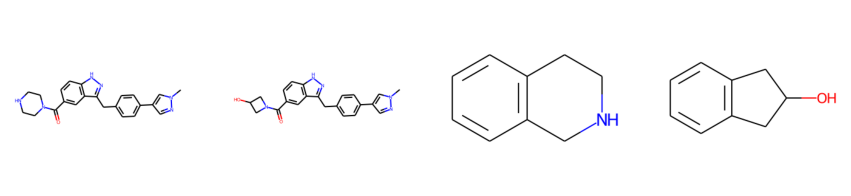

52 N[1*]CCNCC[2*]     >>>>     N[1*]C[C@@H](O)CC[2*]


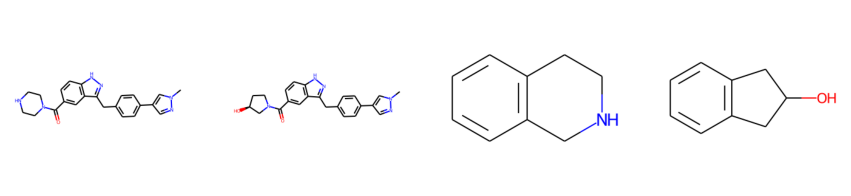

53 c[1*]C(=O)N1CCNCC1     >>>>     c[1*]NC(C)=O


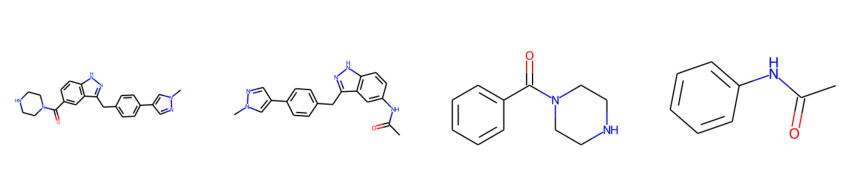

54 c[1*]C(=O)N1CCNCC1     >>>>     c[1*]NS(C)(=O)=O


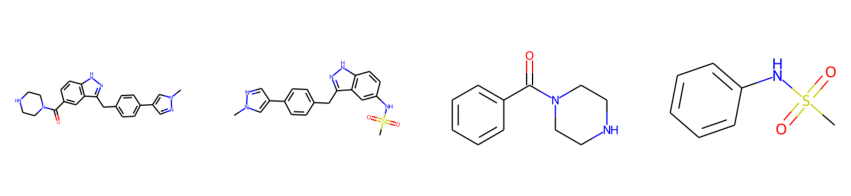

55 N[1*]CCNCC[2*]     >>>>     N[1*]CCCCC[2*]


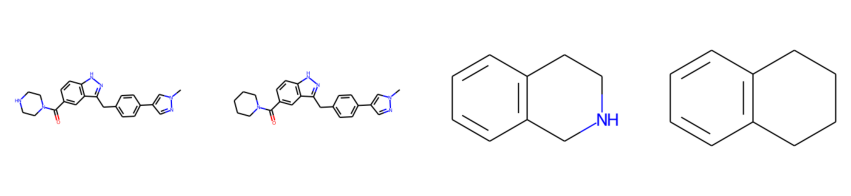

Aborting this pert --> miscellaneous fused ring issue.
57 c[1*]C(=O)N1CCNCC1     >>>>     c[1*]N1CCOCC1


RDKit ERROR: [09:29:09] SMILES Parse Error: extra open parentheses for input: 'c1cccc2c1CC(C2'
[09:29:09] SMILES Parse Error: extra open parentheses for input: 'c1cccc2c1CC(C2'


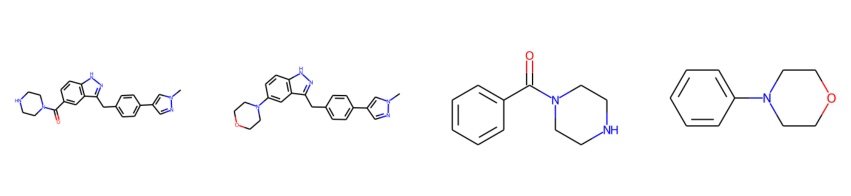

58 C[1*]N1CCNCC1     >>>>     C[2*]NC.C[1*]C(C)(C)O


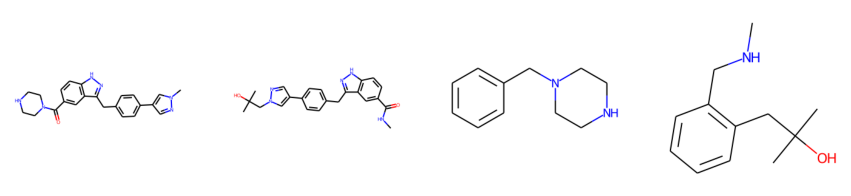

59 c[1*]C(=O)N1CCNCC1     >>>>     c[1*]N1CCCC1=O


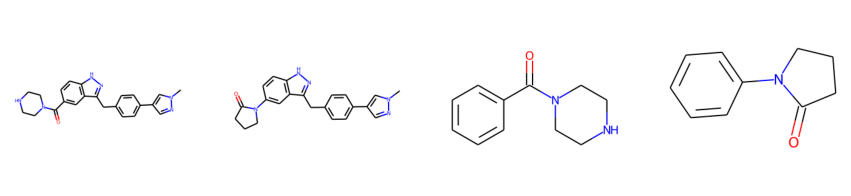

Aborting this pert --> two or more fused rings being perturbed.
61 c[1*]C(=O)N1CCNCC1     >>>>     c[1*]S(=O)(=O)NC1CC1


KeyboardInterrupt: 

In [12]:
# NOTE: THIS CELL WAS INTERRUPTED TO BE ABLE TO UPLOAD TO GITHUB AS SHOWING ALL MOLECULE IMAGES RESULTS IN A IPYNB OF
# ~140MB. RUN THIS CELL TO SETUP THE WHOLE OF FEPSPACE.
fepspace_path = "FEPSPACE_TRAIN/fepspace_perts.csv"

if os.path.exists(fepspace_path):
    os.remove(fepspace_path)


with open(fepspace_path, "a") as fepspace_file:
    writer = csv.writer(fepspace_file)
    # write file header.
    writer.writerow(["ref_perturbation", "ref_target", "num_ha_perturbed", 
                     "newlig1_smi", "newlig2_smi", "input_smarts"])
    
    # iterate over generated combinations. 
    for idx, pert_row in tqdm(all_bm_perts.iterrows(), total=len(all_bm_perts)):
        
        

        # 1. Rewrite SMARTS such that we can easily parse the anchor atom.
        smarts = pert_row["smarts"]
        frags_1, frags_2 = rewriteSMARTS(smarts)  
        
        
        # 2. Graft R groups onto benzene scaffold
        abstract_mol_1 = abstract_mol_2 = None

        img2 = depictMol(Chem.MolFromSmarts(frags_1))
        img3 = depictMol(Chem.MolFromSmarts(frags_2))

        abstract_mol_1 = graftToScaffold(frags_1)
        abstract_mol_2 = graftToScaffold(frags_2)
        
        # 3. If successful grafting, generate a figure (if in notebook)
        if abstract_mol_1 and abstract_mol_2:
            
            if depict_mols:
                print(idx, frags_1, "    >>>>    ", frags_2)
                
                # get input ligands.
                ligpath1 = f"fep_ref_ligands/{pert_row['tgt']}/{pert_row['pert'].split('~')[0]}.sdf"
                ligpath2 = f"fep_ref_ligands/{pert_row['tgt']}/{pert_row['pert'].split('~')[1]}.sdf"
                
                lig1 = Chem.SDMolSupplier(ligpath1)[0]
                lig2 = Chem.SDMolSupplier(ligpath2)[0]
                Chem.RemoveHs(lig1)
                AllChem.Compute2DCoords(lig1)
                Chem.RemoveHs(lig2)
                AllChem.Compute2DCoords(lig2)
                
                img0 = depictMol(lig1)
                img1 = depictMol(lig2)
                
                fig, axes = plt.subplots(1, 4, figsize=(15, 5), gridspec_kw={'width_ratios': [1, 1, 1, 1,]})

                img4 = depictMol(abstract_mol_1)
                img5 = depictMol(abstract_mol_2)

                axes[0].imshow(img0)
                axes[1].imshow(img1)
                axes[2].imshow(img4)
                axes[3].imshow(img5)
                # uncomment to show smarts structures:
#                 axes[2].imshow(img2)
#                 axes[3].imshow(img3)
#                 axes[4].imshow(img4)
#                 axes[5].imshow(img5)


                for ax in axes:
                    ax.axis("off")

                plt.show()

            # 4. Save the new ligands to SMILES format and write information to fep_space file. Each entry will 
            # include the name of the target and ligands will retain their names from the original benchmarking
            # sets for simpler reference down the road.
            writer.writerow([pert_row["pert"], pert_row["tgt"], pert_row["n_ha"], 
                  Chem.MolToSmiles(abstract_mol_1),
                  Chem.MolToSmiles(abstract_mol_2),
                  pert_row["smarts"]
                            ])
            
            # even if not depict_mols, this cell will still output some RDKit warnings. We choose to not suppress these
            # as that is bad practice - these faulty perturbations are aborted in all cases.